# Causal Inference
***

### Table of content

#### [Import Libraries and Initial Setting Up](#import)
#### [Read Preprocessed Data](#read)
#### [Treatment I: Inflight wifi service](#t1)
#### [Experiment I: Inflight wifi service](#e1)

1. [**S Learner** with XBGRegressor](#e1s)
2. [**T Learner** with XBGRegressor](#e1t)
3. [**X Learner** with XBGRegressor](#e1x)

#### [CATE I: Inflight wifi service](#c1)

1. [By **IsBusinessTravel**](#c1bu)
2. [By **Class + IsBusinessTravel**](#c1class)
3. [By **IsLoyalCustomer**](#c1lo)
4. [By **Flight Distance**](#c1ds)

#### [Treatment II: Online boarding](#t2)
#### [Experiment II: Online boarding](#e2)

1. [**S Learner** with XBGRegressor](#e2s)
2. [**T Learner** with XBGRegressor](#e2t)
3. [**X Learner** with XBGRegressor](#e2x)

#### [CATE II: Online boarding](#c2)

1. [By **IsBusinessTravel**](#c2bu)
2. [By **Class + IsBusinessTravel**](#c2class)
3. [By **IsLoyalCustomer**](#c2lo)
4. [By **Age**](#c2age)

<br>

***
<br>


## Import Libraries and Initial Setting Up<a name = "import"></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor, LRSRegressor, XGBTRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from causalml.dataset import make_uplift_classification

from sklearn.linear_model import LinearRegression

/Users/ylfaliang/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/ylfaliang/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/ylfaliang/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [3]:
import sys
import warnings
import pprint

warnings.filterwarnings("ignore")
pp = pprint.PrettyPrinter(compact=True)
pd.set_option('display.max_columns', None)

In [4]:
def make_pretty(styler):
    styler.background_gradient(cmap = sns.color_palette("vlag", as_cmap=True), axis = None)
    styler.format(lambda x: round(x,3))
    return styler

<br>

## Read Preprocessed Data<a name = "read"></a>

In [5]:
airplane = pd.read_csv('../preprocessing/data/airplane_train_processed.csv')
airplane_norm = pd.read_csv('../preprocessing/data/airplane_train_processed_normalized.csv')

In [6]:
display(airplane.head())
display(airplane_norm.head())

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0,satisfied


,cat__Gender_Female,cat__Gender_Male,cat__Customer Type_Loyal Customer,cat__Customer Type_disloyal Customer,cat__Type of Travel_Business travel,cat__Type of Travel_Personal Travel,cat__Class_Business,cat__Class_Eco,cat__Class_Eco Plus,std__Age,std__Flight Distance,std__Departure Delay in Minutes,std__Arrival Delay in Minutes,remainder__Inflight wifi service,remainder__Departure/Arrival time convenient,remainder__Ease of Online booking,remainder__Gate location,remainder__Food and drink,remainder__Online boarding,remainder__Seat comfort,remainder__Inflight entertainment,remainder__On-board service,remainder__Leg room service,remainder__Baggage handling,remainder__Checkin service,remainder__Inflight service,remainder__Cleanliness,remainder__satisfaction
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.746813,-0.729928,0.472121,0.198061,3,4,3,1,5,3,5,5,4,3,4,4,5,5,neutral or dissatisfied
1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.952197,-0.956229,-0.422700,-0.243968,3,2,3,3,1,3,1,1,1,5,3,1,4,1,neutral or dissatisfied
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.885979,-0.043987,-0.459984,-0.464982,2,2,2,2,5,5,5,5,4,3,4,4,4,5,satisfied
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.952197,-0.627339,-0.049858,-0.133461,2,5,5,5,2,2,2,2,2,5,3,1,4,2,neutral or dissatisfied
4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.431649,-0.977350,-0.459984,-0.464982,3,3,3,3,4,5,5,3,3,4,4,3,3,3,satisfied


In [7]:
for col in ["Gender","Customer Type","Type of Travel","Class"]:
    display(pd.DataFrame(airplane[col].value_counts(normalize = True)))

,Gender
Female,0.507398
Male,0.492602


,Customer Type
Loyal Customer,0.816972
disloyal Customer,0.183028


,Type of Travel
Business travel,0.689376
Personal Travel,0.310624


,Class
Business,0.477660
Eco,0.450128
Eco Plus,0.072212


In [8]:
airplane_causal = airplane.copy()
airplane_causal["Gender"] = np.where(airplane_causal["Gender"] == "Male", 1, 0)
airplane_causal["Customer Type"] = np.where(airplane_causal["Customer Type"] == "Loyal Customer", 1, 0)
airplane_causal["Type of Travel"] = np.where(airplane_causal["Type of Travel"] == "Business travel", 1, 0)
airplane_causal.rename(columns = {"Gender":"IsMale",
                                  "Customer Type":"IsLoyalCustomer",
                                  "Type of Travel":"IsBusinessTravel"}, 
                       inplace = True)
airplane_causal = pd.get_dummies(airplane_causal, columns = ["Class"])

In [9]:
display(airplane_causal.head())

,IsMale,IsLoyalCustomer,Age,IsBusinessTravel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Class_Business,Class_Eco,Class_Eco Plus
0,1,1,13,0,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18,neutral or dissatisfied,0,0,1
1,1,0,25,1,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6,neutral or dissatisfied,1,0,0
2,0,1,26,1,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0,satisfied,1,0,0
3,0,1,25,1,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9,neutral or dissatisfied,1,0,0
4,1,1,61,1,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0,satisfied,1,0,0


<br>

## Treatment I: Inflight wifi service<a name = "t1"></a>
<br>

- **Target**: *satisfication*

In [10]:
display(pd.DataFrame(airplane_causal["satisfaction"].value_counts(normalize = True)))
airplane_causal["satisfaction"] = np.where(airplane_causal["satisfaction"] == "satisfied", 1, 0)

y = airplane_causal["satisfaction"]

,satisfaction
neutral or dissatisfied,0.566243
satisfied,0.433757


<br>

- **Treatment**: *Good Wifi Service*<br>**Control**: *Bad Wifi Service*

In [11]:
treatment =  pd.Series(np.where(airplane_causal["Inflight wifi service"] >= 4,
                                "Good Wifi Service", "Bad Wifi Service"), name = "Inflight wifi service")
display(pd.DataFrame(treatment.value_counts(normalize = True)))

,Inflight wifi service
Bad Wifi Service,0.698903
Good Wifi Service,0.301097


<br>

- **Other features**

In [12]:
X = airplane_causal.drop(["satisfaction", "Inflight wifi service"], axis = 1)
display(X.head())

,IsMale,IsLoyalCustomer,Age,IsBusinessTravel,Flight Distance,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Class_Business,Class_Eco,Class_Eco Plus
0,1,1,13,0,460,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18,0,0,1
1,1,0,25,1,235,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6,1,0,0
2,0,1,26,1,1142,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0,1,0,0
3,0,1,25,1,562,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9,1,0,0
4,1,1,61,1,214,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0,1,0,0


<br>

<font color="mediumorchid">*Check feature names*</font>

In [13]:
feature_names = list(X.columns)
print("Number of features: " + str(len(feature_names)) + "\n")
pp.pprint(feature_names)

Number of features: 23

['IsMale', 'IsLoyalCustomer', 'Age', 'IsBusinessTravel', 'Flight Distance',
 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location',
 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment',
 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service',
 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes',
 'Arrival Delay in Minutes', 'Class_Business', 'Class_Eco', 'Class_Eco Plus']


<br>

<font color="mediumorchid">*Length check*</font>

In [14]:
print("Length check pass?",len(y) == len(treatment) == len(X))

Length check pass? True


## Experiment I: Inflight wifi service<a name = "e1"></a>

In [15]:
comparison = pd.DataFrame(columns = ["Meta Learner", 
                                     "Base Model (Regressor)", 
                                     "ATE", 
                                     "ATE lb", 
                                     "ATE ub",
                                     "Top Features (auto)"])

In [16]:
display(pd.concat([airplane_causal["satisfaction"], treatment], 
                  axis = 1).pivot_table(values = "satisfaction",
                                        index = "Inflight wifi service",
                                        aggfunc = [np.mean, np.size],
                                        margins = True))

,mean,size
,satisfaction,satisfaction
Inflight wifi service,,
Bad Wifi Service,0.300520,71892
Good Wifi Service,0.743026,30972
All,0.433757,102864


### 1. S Learner with XGBRegressor<a name = "e1s"></a>

In [17]:
s_learner = BaseSRegressor(XGBRegressor(n_jobs = -1), control_name = "Bad Wifi Service")
te = s_learner.estimate_ate(X, treatment, y)
result = ["S Learner", "XGBoost", te[0], "NA", "NA"]

In [18]:
s_learner_tau = s_learner.fit_predict(X, treatment, y)

importance = s_learner.get_importance(X = X,
                                      tau = s_learner_tau,
                                      normalize = True, 
                                      method = "auto", 
                                      features = feature_names)

display(pd.DataFrame(importance).rename(columns = {"Good Wifi Service":"Importance"}))
result.append(list(pd.DataFrame(importance).iloc[:3,0].index))

,Importance
Class_Business,0.209725
IsLoyalCustomer,0.149875
Gate location,0.139872
Online boarding,0.101946
Inflight entertainment,0.086272
Ease of Online booking,0.082685
IsBusinessTravel,0.068599
Arrival Delay in Minutes,0.041125
Flight Distance,0.040708
Departure/Arrival time convenient,0.016836


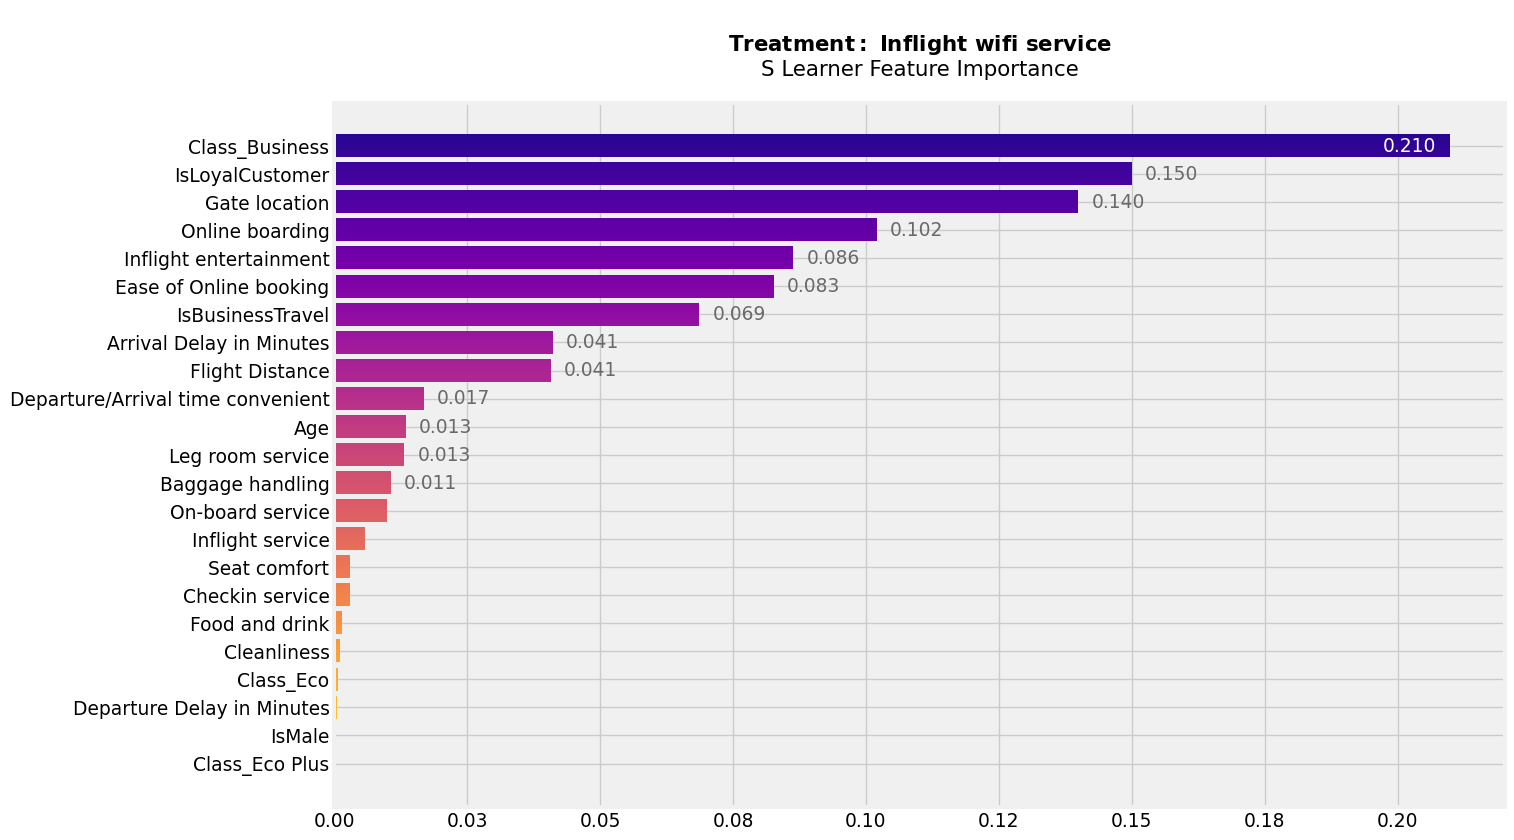

In [19]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 96, facecolor = "white")

bar = ax.barh(importance["Good Wifi Service"].index, importance["Good Wifi Service"], color = "olivedrab")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title("\n"+r"$\bf{Treatment:\ Inflight\ wifi\ service}$"+"\n"+"S Learner Feature Importance", pad=20, fontsize=16)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}'))

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=1, origin='lower',
                  vmin=ymin, vmax=ymax, cmap="plasma")
    ax.axis([xmin, xmax, ymax, ymin])

gradientbars_sliced(bar)

for rect in ax.patches:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    if x_value > 0.01:
        if x_value < 0.15:
            space = 50
            ha = 'right'
            color = "dimgrey"
        else:
            space = -50
            ha = 'left'
            color = "white"

        label = '{:,.3f}'.format(x_value)

        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords='offset points',
                     va='center', ha=ha, color = color)

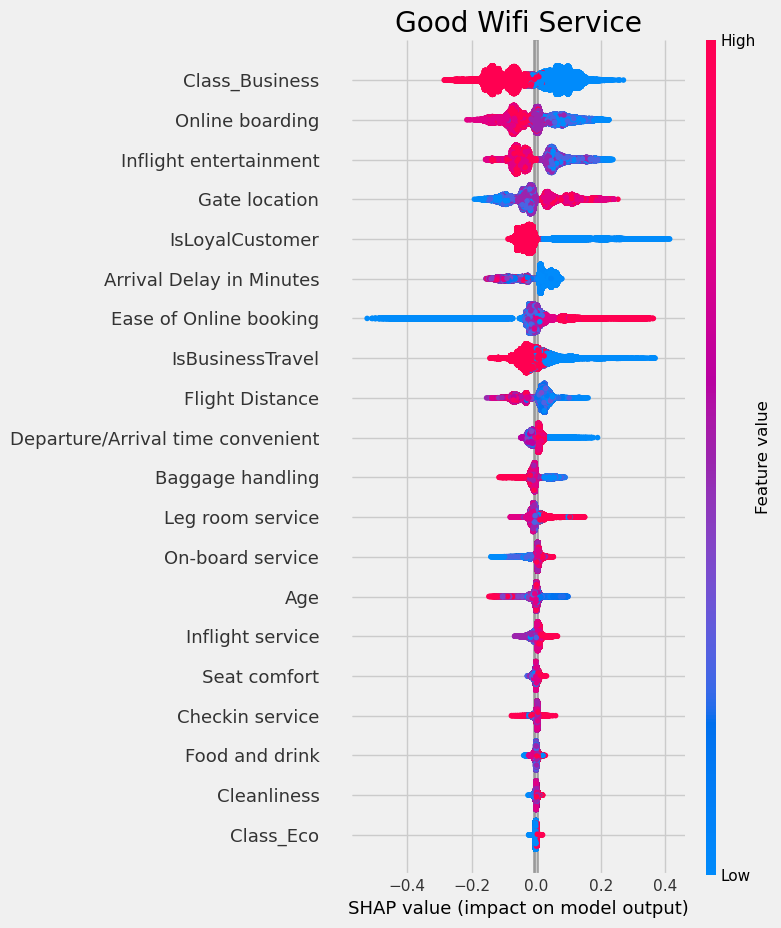

In [20]:
s_learner.plot_shap_values(X=X, tau=s_learner_tau, features=feature_names)

In [21]:
comparison.loc[len(comparison)] = result
display(comparison)

,Meta Learner,Base Model (Regressor),ATE,ATE lb,ATE ub,Top Features (auto)
0,S Learner,XGBoost,0.1852,NA,NA,"[Class_Business, IsLoyalCustomer, Gate location]"


### 2. T Learner with XGBTRegressor<a name = "e1t"></a>

In [22]:
t_learner = XGBTRegressor(control_name = "Bad Wifi Service")
te, lb, ub = t_learner.estimate_ate(X, treatment, y)
result = ["T Learner", "XGBoost", te[0], lb[0], ub[0]]

In [23]:
t_learner_tau = t_learner.fit_predict(X, treatment, y)

importance = t_learner.get_importance(X = X,
                                      tau = t_learner_tau,
                                      normalize = True, 
                                      method = 'auto', 
                                      features = feature_names)
display(pd.DataFrame(importance).rename(columns = {"Good Wifi Service":"Importance"}))
result.append(list(pd.DataFrame(importance).iloc[:3,0].index))

,Importance
Class_Business,0.212761
IsLoyalCustomer,0.188629
Departure/Arrival time convenient,0.146261
Online boarding,0.100033
Ease of Online booking,0.077504
Gate location,0.057283
Inflight entertainment,0.044768
IsBusinessTravel,0.032905
Flight Distance,0.024208
Arrival Delay in Minutes,0.022987


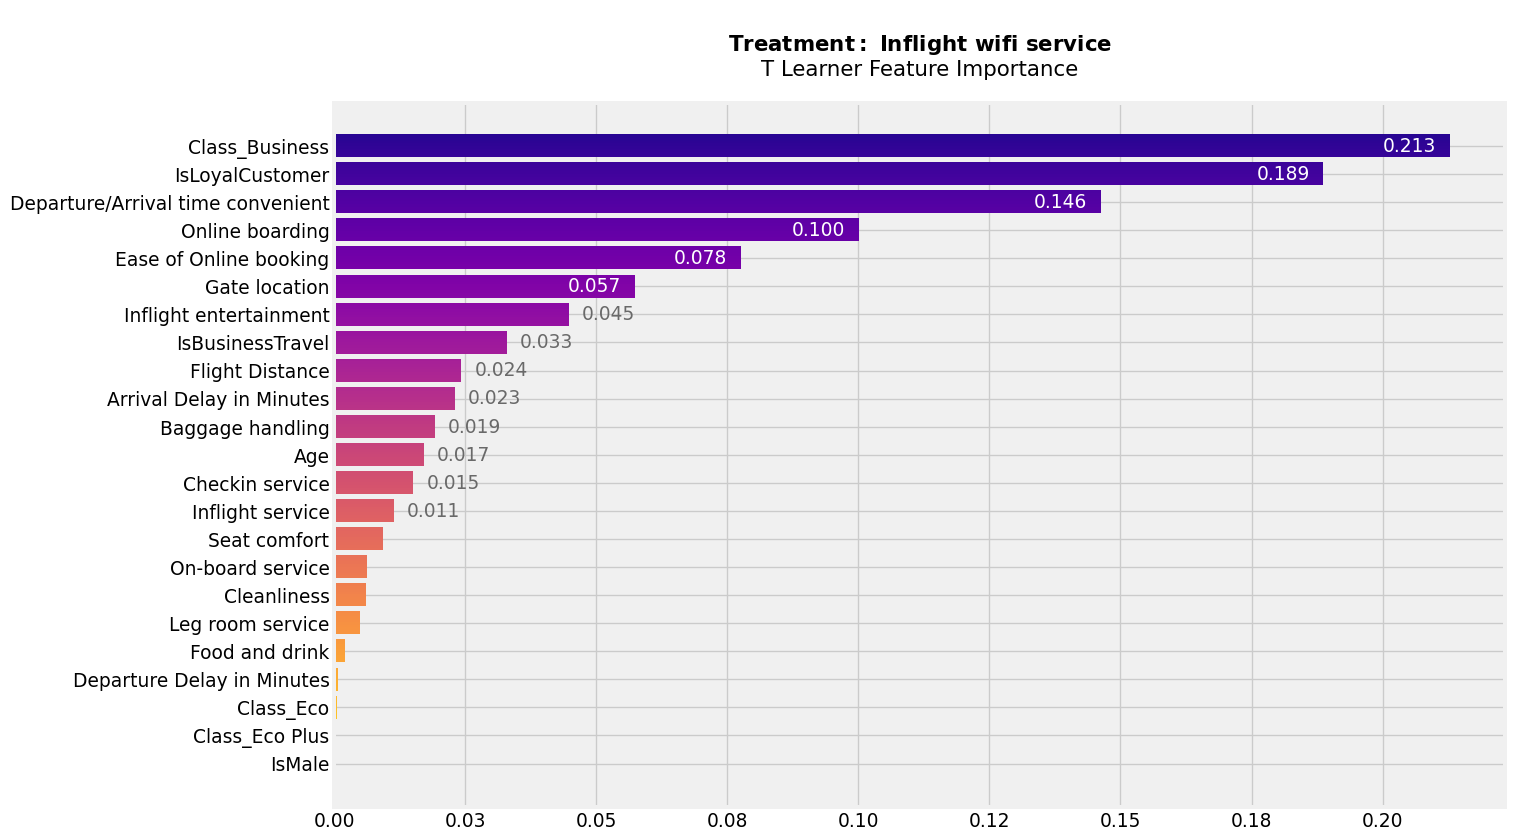

In [24]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 96, facecolor = "white")

bar = ax.barh(importance["Good Wifi Service"].index, importance["Good Wifi Service"], color = "olivedrab")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title("\n"+r"$\bf{Treatment:\ Inflight\ wifi\ service}$"+"\n"+"T Learner Feature Importance", pad=20, fontsize=16)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}'))

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=1, origin='lower',
                  vmin=ymin, vmax=ymax, cmap="plasma")
    ax.axis([xmin, xmax, ymax, ymin])

gradientbars_sliced(bar)

for rect in ax.patches:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    if x_value > 0.01:
        if x_value < 0.05:
            space = 50
            ha = 'right'
            color = "dimgrey"
        else:
            space = -50
            ha = 'left'
            color = "white"

        label = '{:,.3f}'.format(x_value)

        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords='offset points',
                     va='center', ha=ha, color = color)

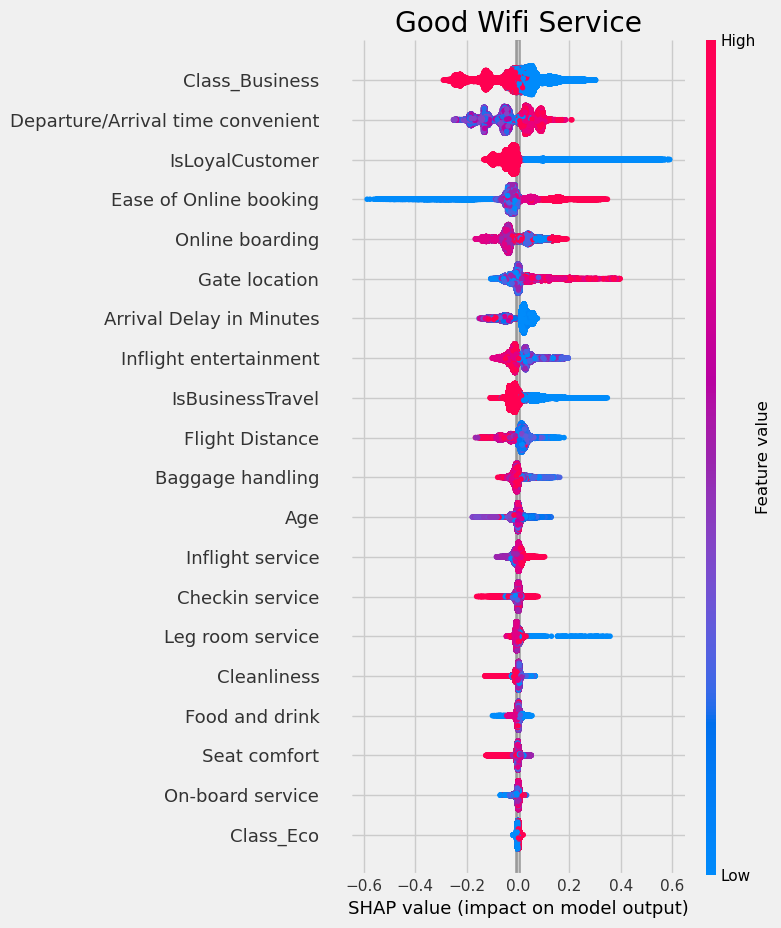

In [25]:
t_learner.plot_shap_values(X = X, tau = t_learner_tau, features = feature_names)

In [26]:
comparison.loc[len(comparison)] = result
display(comparison)

,Meta Learner,Base Model (Regressor),ATE,ATE lb,ATE ub,Top Features (auto)
0,S Learner,XGBoost,0.185200,NA,NA,"[Class_Business, IsLoyalCustomer, Gate location]"
1,T Learner,XGBoost,0.232139,0.228484,0.235795,"[Class_Business, IsLoyalCustomer, Departure/Ar..."


### 3. X Learner with XGBRegressor<a name = "e1x"></a>

In [27]:
x_learner = BaseXRegressor(XGBRegressor(n_jobs = -1), control_name = "Bad Wifi Service")
te, lb, ub = x_learner.estimate_ate(X, treatment, y)
result = ["X Learner", "XGBoost", te[0], lb[0], ub[0]]

In [28]:
x_learner_tau = x_learner.fit_predict(X, treatment, y)

importance = x_learner.get_importance(X = X,
                                      tau = x_learner_tau,
                                      normalize = True, 
                                      method = 'auto', 
                                      features = feature_names)
display(pd.DataFrame(importance).rename(columns = {"Good Wifi Service":"Importance"}))
result.append(list(pd.DataFrame(importance).iloc[:3,0].index))

,Importance
Class_Business,0.270819
IsLoyalCustomer,0.227077
Departure/Arrival time convenient,0.175276
Inflight entertainment,0.091488
Gate location,0.069875
Ease of Online booking,0.038700
Online boarding,0.027678
IsBusinessTravel,0.026260
Arrival Delay in Minutes,0.017690
Flight Distance,0.013075


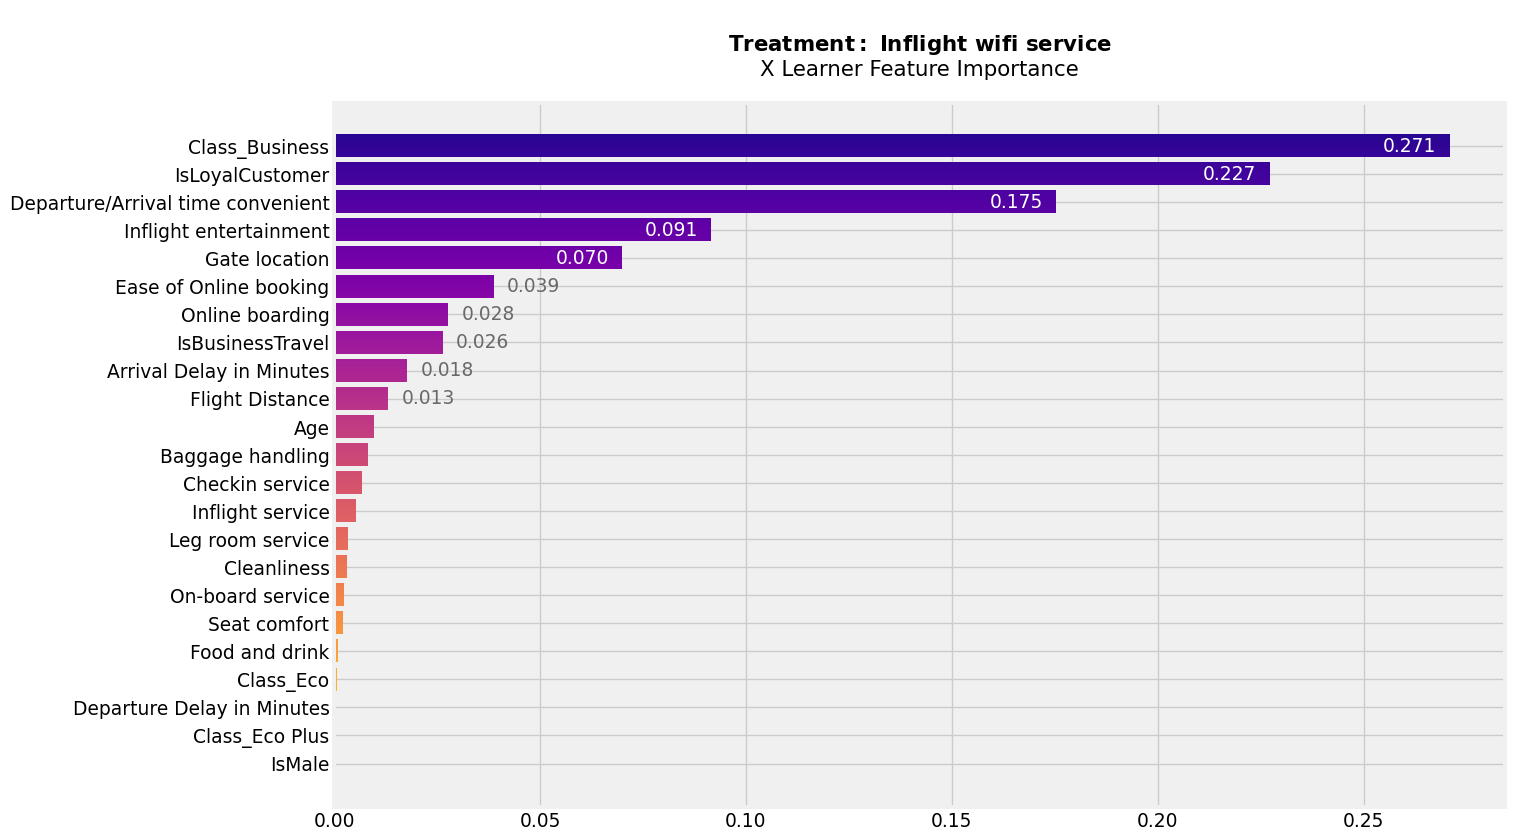

In [29]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 96, facecolor = "white")

bar = ax.barh(importance["Good Wifi Service"].index, importance["Good Wifi Service"], color = "olivedrab")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title("\n"+r"$\bf{Treatment:\ Inflight\ wifi\ service}$"+"\n"+"X Learner Feature Importance", pad=20, fontsize=16)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}'))

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=1, origin='lower',
                  vmin=ymin, vmax=ymax, cmap="plasma")
    ax.axis([xmin, xmax, ymax, ymin])

gradientbars_sliced(bar)

for rect in ax.patches:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    if x_value > 0.01:
        if x_value < 0.05:
            space = 50
            ha = 'right'
            color = "dimgrey"
        else:
            space = -50
            ha = 'left'
            color = "white"

        label = '{:,.3f}'.format(x_value)

        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords='offset points',
                     va='center', ha=ha, color = color)

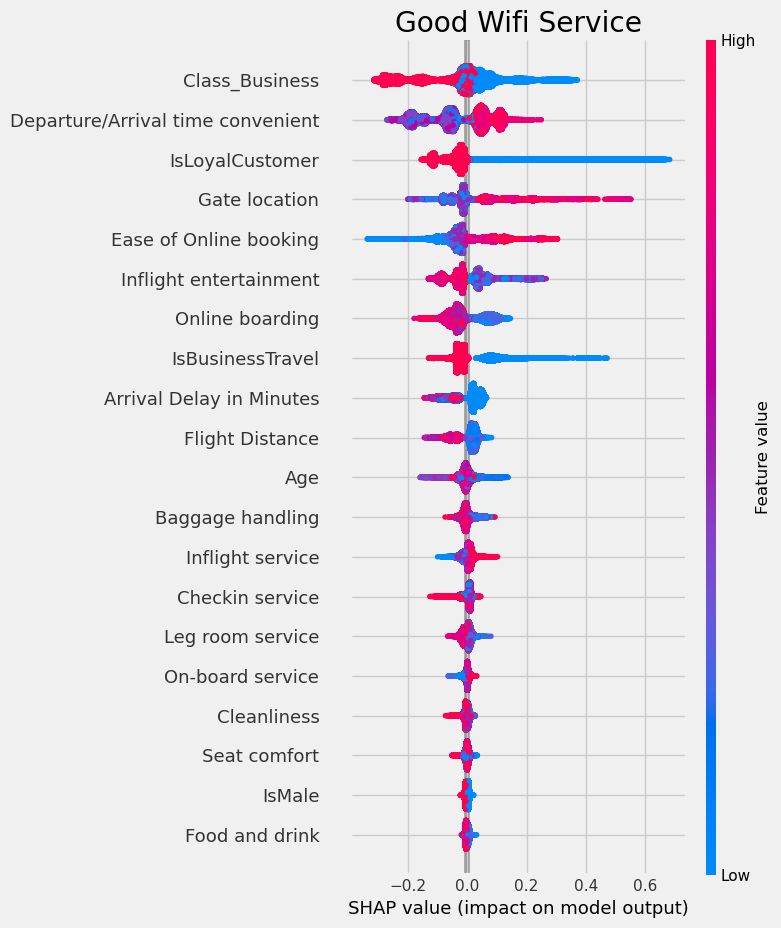

In [30]:
x_learner.plot_shap_values(X = X, tau = x_learner_tau, features = feature_names)

In [31]:
comparison.loc[len(comparison)] = result
pd.set_option('display.max_colwidth', None)
display(comparison)

,Meta Learner,Base Model (Regressor),ATE,ATE lb,ATE ub,Top Features (auto)
0,S Learner,XGBoost,0.185200,NA,NA,"[Class_Business, IsLoyalCustomer, Gate location]"
1,T Learner,XGBoost,0.232139,0.228484,0.235795,"[Class_Business, IsLoyalCustomer, Departure/Arrival time convenient]"
2,X Learner,XGBoost,0.180782,0.176891,0.184673,"[Class_Business, IsLoyalCustomer, Departure/Arrival time convenient]"


## CATE I: Inflight wifi service<a name = "c1"></a>

In [32]:
airplane_ITE_t = t_learner.fit_predict(X, treatment, y)
display(airplane_ITE_t)

array([[-0.20262413],
       [ 0.22809924],
       [-0.02351022],
       ...,
       [ 0.75633895],
       [ 0.60090393],
       [-0.00123556]])

In [33]:
airplane_causal["ITE"] = airplane_ITE_t
display(airplane_causal.head())

,IsMale,IsLoyalCustomer,Age,IsBusinessTravel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Class_Business,Class_Eco,Class_Eco Plus,ITE
0,1,1,13,0,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18,0,0,0,1,-0.202624
1,1,0,25,1,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6,0,1,0,0,0.228099
2,0,1,26,1,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0,1,1,0,0,-0.023510
3,0,1,25,1,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9,0,1,0,0,0.938868
4,1,1,61,1,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0,1,1,0,0,-0.193666


### 1. By IsBusinessTravel<a name = "c1bu"></a>

In [34]:
CATE_bu = airplane_causal[["IsBusinessTravel", "ITE"]]
CATE_bu["IsBusinessTravel"] = np.where(CATE_bu["IsBusinessTravel"] == 1, "Yes", "No")
CATE_bu.groupby(["IsBusinessTravel"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

,CATE
IsBusinessTravel,
No,0.361
Yes,0.174


### 2. By Class + IsBusinessTravel<a name = "c1class"></a>

In [35]:
CATE_class = pd.concat([CATE_bu, airplane["Class"]], axis = 1)
CATE_class.groupby(["IsBusinessTravel","Class"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

### 3. By IsLoyalCustomer<a name = "c1lo"></a>

In [36]:
CATE_lo = airplane_causal[["IsLoyalCustomer", "ITE"]]
CATE_lo["IsLoyalCustomer"] = np.where(CATE_lo["IsLoyalCustomer"] == 1, "Yes", "No")
CATE_lo.groupby(["IsLoyalCustomer"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

,CATE
IsLoyalCustomer,
No,0.457
Yes,0.182


### 4. By Flight Distance<a name = "c1ds"></a>

In [37]:
CATE_ds = airplane_causal[["Flight Distance", "ITE"]]
def flightDist(x):
    if x/560 < 3:
        return "Short"
    else:
        return "Mid-Long"
CATE_ds["Flight Distance"] = CATE_ds["Flight Distance"].apply(lambda x: flightDist(x))
CATE_ds.groupby(["Flight Distance"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

,CATE
Flight Distance,
Mid-Long,0.03
Short,0.303


## Treatment II: Online boarding<a name = "t2"></a>

<br>

- **Target**: *satisfication* (stay the same)<br><br>
- **Treatment**: *Good Wifi Service*<br>**Control**: *Bad Wifi Service*

In [38]:
treatment =  pd.Series(np.where(airplane_causal["Online boarding"] >= 4,
                                "Good Online Boarding", "Bad Online Boarding"), name = "Online boarding")
display(pd.DataFrame(treatment.value_counts(normalize = True)))

,Online boarding
Bad Online Boarding,0.504734
Good Online Boarding,0.495266


- **Other features**

In [39]:
X = airplane_causal.drop(["satisfaction", "Online boarding", "ITE"], axis = 1)
display(X.head())

,IsMale,IsLoyalCustomer,Age,IsBusinessTravel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Class_Business,Class_Eco,Class_Eco Plus
0,1,1,13,0,460,3,4,3,1,5,5,5,4,3,4,4,5,5,25,18,0,0,1
1,1,0,25,1,235,3,2,3,3,1,1,1,1,5,3,1,4,1,1,6,1,0,0
2,0,1,26,1,1142,2,2,2,2,5,5,5,4,3,4,4,4,5,0,0,1,0,0
3,0,1,25,1,562,2,5,5,5,2,2,2,2,5,3,1,4,2,11,9,1,0,0
4,1,1,61,1,214,3,3,3,3,4,5,3,3,4,4,3,3,3,0,0,1,0,0


<br>

<font color="mediumorchid">*Check feature names*</font>

In [40]:
feature_names = list(X.columns)
print("Number of features: " + str(len(feature_names)) + "\n")
pp.pprint(feature_names)

Number of features: 23

['IsMale', 'IsLoyalCustomer', 'Age', 'IsBusinessTravel', 'Flight Distance',
 'Inflight wifi service', 'Departure/Arrival time convenient',
 'Ease of Online booking', 'Gate location', 'Food and drink', 'Seat comfort',
 'Inflight entertainment', 'On-board service', 'Leg room service',
 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness',
 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Class_Business',
 'Class_Eco', 'Class_Eco Plus']


<br>

<font color="mediumorchid">*Length Check*</font>

In [41]:
print("Length check pass?",len(y) == len(treatment) == len(X))

Length check pass? True


## Experiment II: Online boarding<a name = "e2"></a>

In [42]:
comparison = pd.DataFrame(columns = ["Meta Learner", 
                                     "Base Model (Regressor)", 
                                     "ATE", 
                                     "ATE lb", 
                                     "ATE ub",
                                     "Top Features (auto)"])

In [43]:
display(pd.concat([airplane_causal["satisfaction"], treatment], 
                  axis = 1).pivot_table(values = "satisfaction",
                                        index = "Online boarding",
                                        aggfunc = [np.mean, np.size],
                                        margins = True))

,mean,size
,satisfaction,satisfaction
Online boarding,,
Bad Online Boarding,0.148616,51919
Good Online Boarding,0.724350,50945
All,0.433757,102864


### 1. S Learner with XGBRegressor<a name = "e2s"></a>

In [44]:
s_learner = BaseSRegressor(XGBRegressor(n_jobs = -1), control_name = "Bad Online Boarding")
te = s_learner.estimate_ate(X, treatment, y)
result = ["S Learner", "XGBoost", te[0], "NA", "NA"]

In [45]:
s_learner_tau = s_learner.fit_predict(X, treatment, y)

importance = s_learner.get_importance(X = X,
                                      tau = s_learner_tau,
                                      normalize = True, 
                                      method = "auto", 
                                      features = feature_names)

display(pd.DataFrame(importance).rename(columns = {"Good Online Boarding":"Importance"}))
result.append(list(pd.DataFrame(importance).iloc[:3,0].index))

,Importance
Inflight wifi service,0.177299
IsLoyalCustomer,0.114117
Seat comfort,0.099712
Inflight entertainment,0.098217
IsBusinessTravel,0.080653
Cleanliness,0.070841
Checkin service,0.065162
Leg room service,0.047999
On-board service,0.045039
Class_Business,0.041546


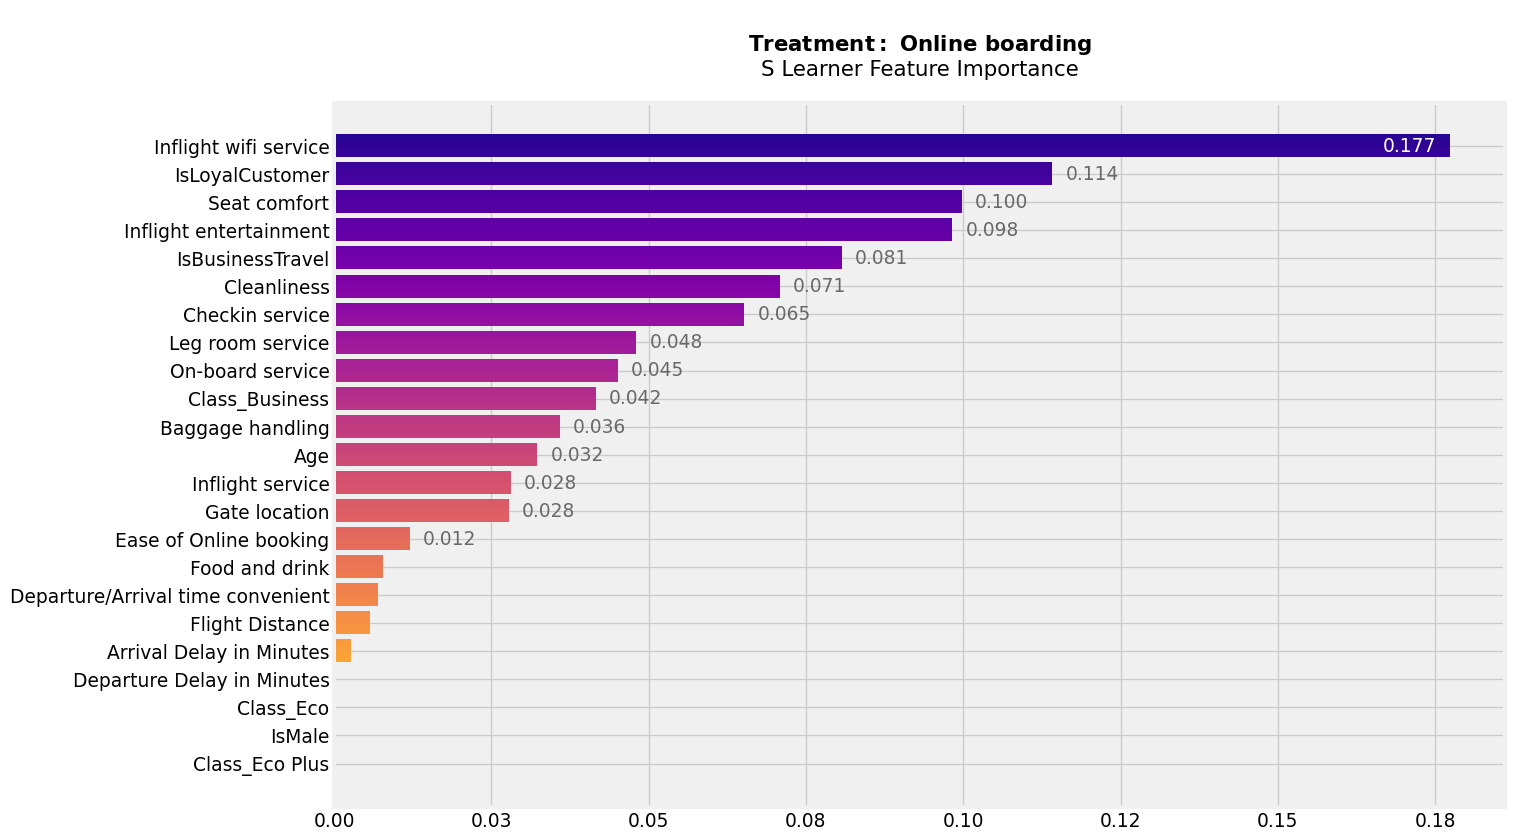

In [46]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 96, facecolor = "white")

bar = ax.barh(importance["Good Online Boarding"].index, importance["Good Online Boarding"])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title("\n"+r"$\bf{Treatment:\ Online\ boarding}$"+"\n"+"S Learner Feature Importance", pad=20, fontsize=16)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}'))

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=1, origin='lower',
                  vmin=ymin, vmax=ymax, cmap="plasma")
    ax.axis([xmin, xmax, ymax, ymin])

gradientbars_sliced(bar)

for rect in ax.patches:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    if x_value > 0.01:
        if x_value < 0.15:
            space = 50
            ha = 'right'
            color = "dimgrey"
        else:
            space = -50
            ha = 'left'
            color = "white"

        label = '{:,.3f}'.format(x_value)

        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords='offset points',
                     va='center', ha=ha, color = color)

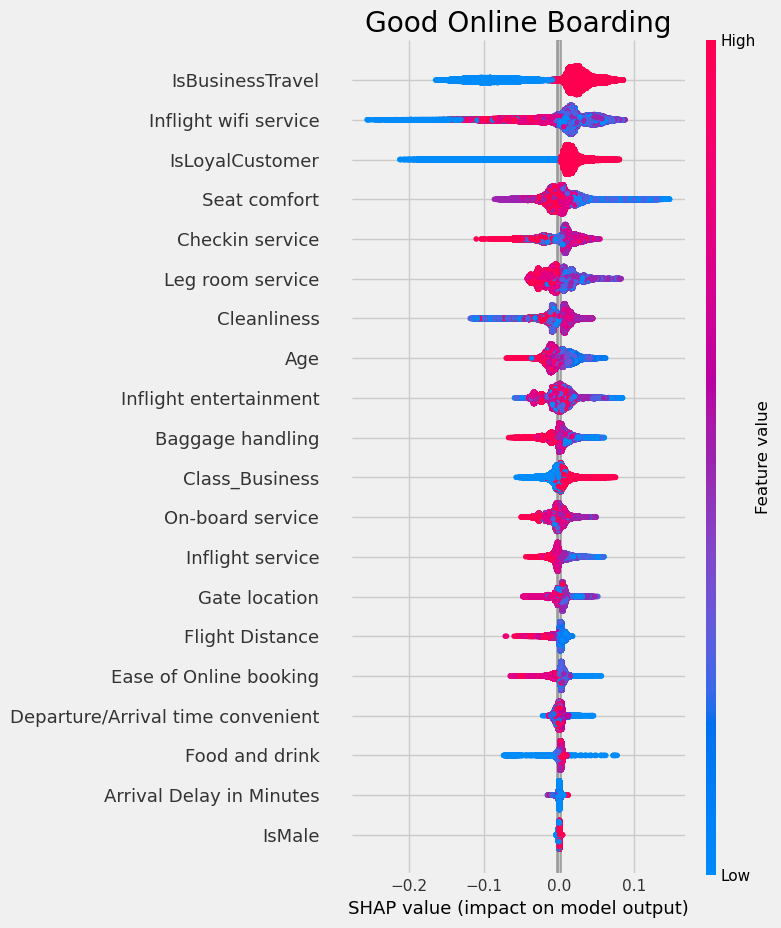

In [47]:
s_learner.plot_shap_values(X=X, tau=s_learner_tau, features=feature_names)

In [48]:
comparison.loc[len(comparison)] = result
display(comparison)

,Meta Learner,Base Model (Regressor),ATE,ATE lb,ATE ub,Top Features (auto)
0,S Learner,XGBoost,0.065257,NA,NA,"[Inflight wifi service, IsLoyalCustomer, Seat comfort]"


### 2. T Learner with XGBTRegressor<a name = "e2t"></a>

In [49]:
t_learner = XGBTRegressor(control_name = "Bad Online Boarding")
te, lb, ub = t_learner.estimate_ate(X, treatment, y)
result = ["T Learner", "XGBoost", te[0], lb[0], ub[0]]

In [50]:
t_learner_tau = t_learner.fit_predict(X, treatment, y)

importance = t_learner.get_importance(X = X,
                                      tau = t_learner_tau,
                                      normalize = True, 
                                      method = 'auto', 
                                      features = feature_names)
display(pd.DataFrame(importance).rename(columns = {"Good Online Boarding":"Importance"}))
result.append(list(pd.DataFrame(importance).iloc[:3,0].index))

,Importance
Seat comfort,0.135944
Inflight wifi service,0.122669
Age,0.085842
Class_Business,0.075789
IsLoyalCustomer,0.072361
IsBusinessTravel,0.070560
Inflight service,0.066909
Cleanliness,0.065718
Checkin service,0.065132
Baggage handling,0.046725


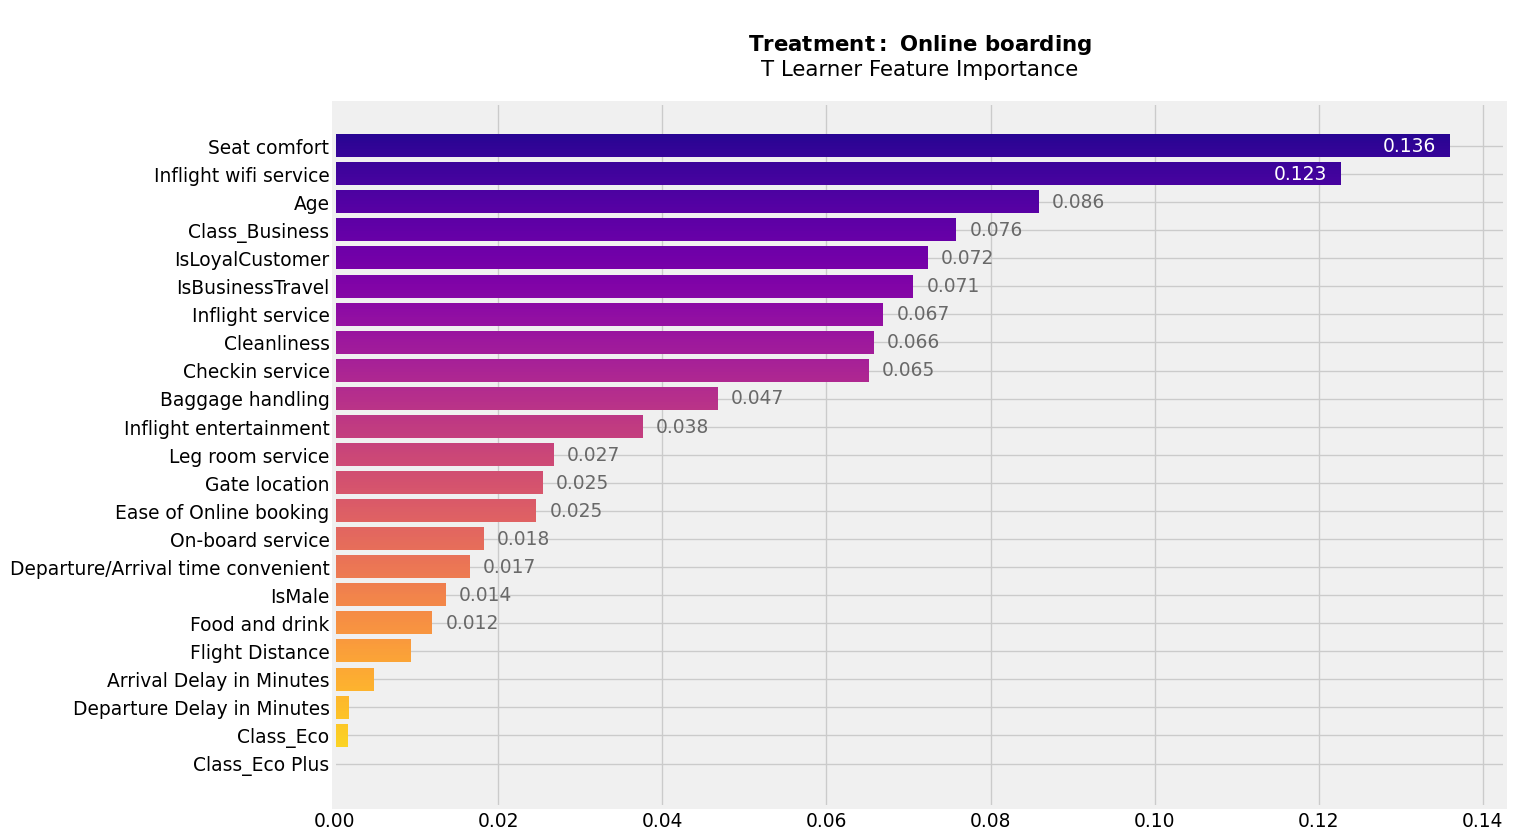

In [51]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 96, facecolor = "white")

bar = ax.barh(importance["Good Online Boarding"].index, importance["Good Online Boarding"])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title("\n"+r"$\bf{Treatment:\ Online\ boarding}$"+"\n"+"T Learner Feature Importance", pad=20, fontsize=16)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}'))

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=1, origin='lower',
                  vmin=ymin, vmax=ymax, cmap="plasma")
    ax.axis([xmin, xmax, ymax, ymin])

gradientbars_sliced(bar)

for rect in ax.patches:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    if x_value > 0.01:
        if x_value < 0.1:
            space = 50
            ha = 'right'
            color = "dimgrey"
        else:
            space = -50
            ha = 'left'
            color = "white"

        label = '{:,.3f}'.format(x_value)

        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords='offset points',
                     va='center', ha=ha, color = color)

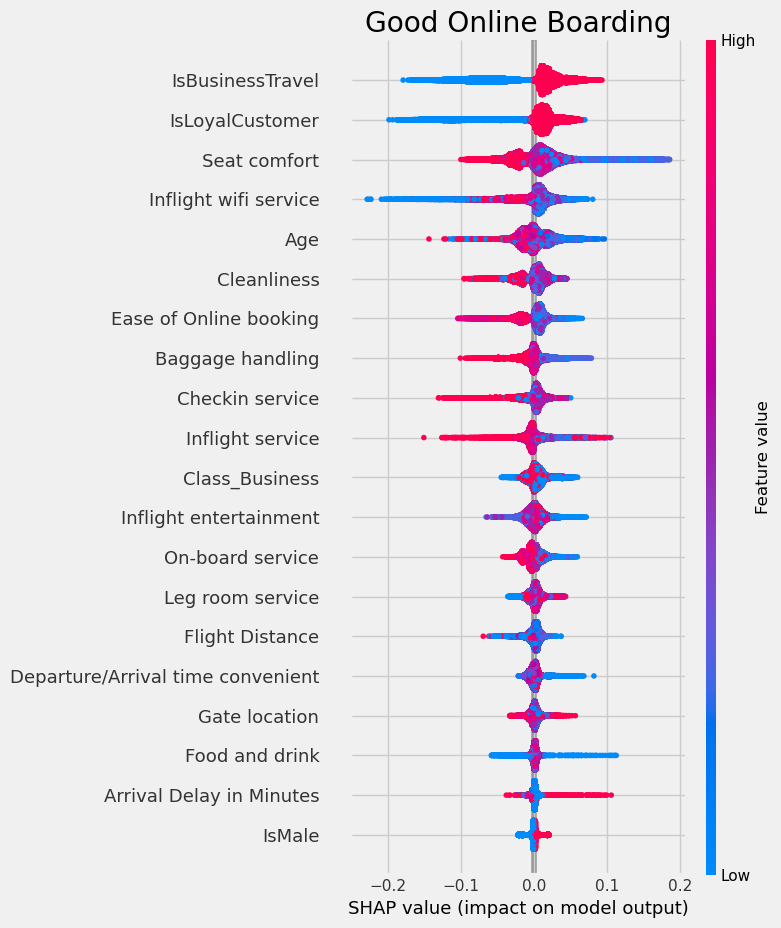

In [52]:
t_learner.plot_shap_values(X = X, tau = t_learner_tau, features = feature_names)

In [53]:
comparison.loc[len(comparison)] = result
display(comparison)

,Meta Learner,Base Model (Regressor),ATE,ATE lb,ATE ub,Top Features (auto)
0,S Learner,XGBoost,0.065257,NA,NA,"[Inflight wifi service, IsLoyalCustomer, Seat comfort]"
1,T Learner,XGBoost,0.055761,0.053636,0.057886,"[Seat comfort, Inflight wifi service, Age]"


### 3. X Learner with XGBRegressor<a name = "e2x"></a>

In [54]:
x_learner = BaseXRegressor(XGBRegressor(n_jobs = -1), control_name = "Bad Online Boarding")
te, lb, ub = x_learner.estimate_ate(X, treatment, y)
result = ["X Learner", "XGBoost", te[0], lb[0], ub[0]]

In [55]:
x_learner_tau = x_learner.fit_predict(X, treatment, y)

importance = x_learner.get_importance(X = X,
                                      tau = x_learner_tau,
                                      normalize = True, 
                                      method = 'auto', 
                                      features = feature_names)
display(pd.DataFrame(importance).rename(columns = {"Good Online Boarding":"Importance"}))
result.append(list(pd.DataFrame(importance).iloc[:3,0].index))

,Importance
IsLoyalCustomer,0.132718
Seat comfort,0.113548
Inflight wifi service,0.098103
Age,0.097894
IsBusinessTravel,0.091567
Inflight service,0.089894
Inflight entertainment,0.086125
Cleanliness,0.065442
Leg room service,0.032735
Baggage handling,0.028819


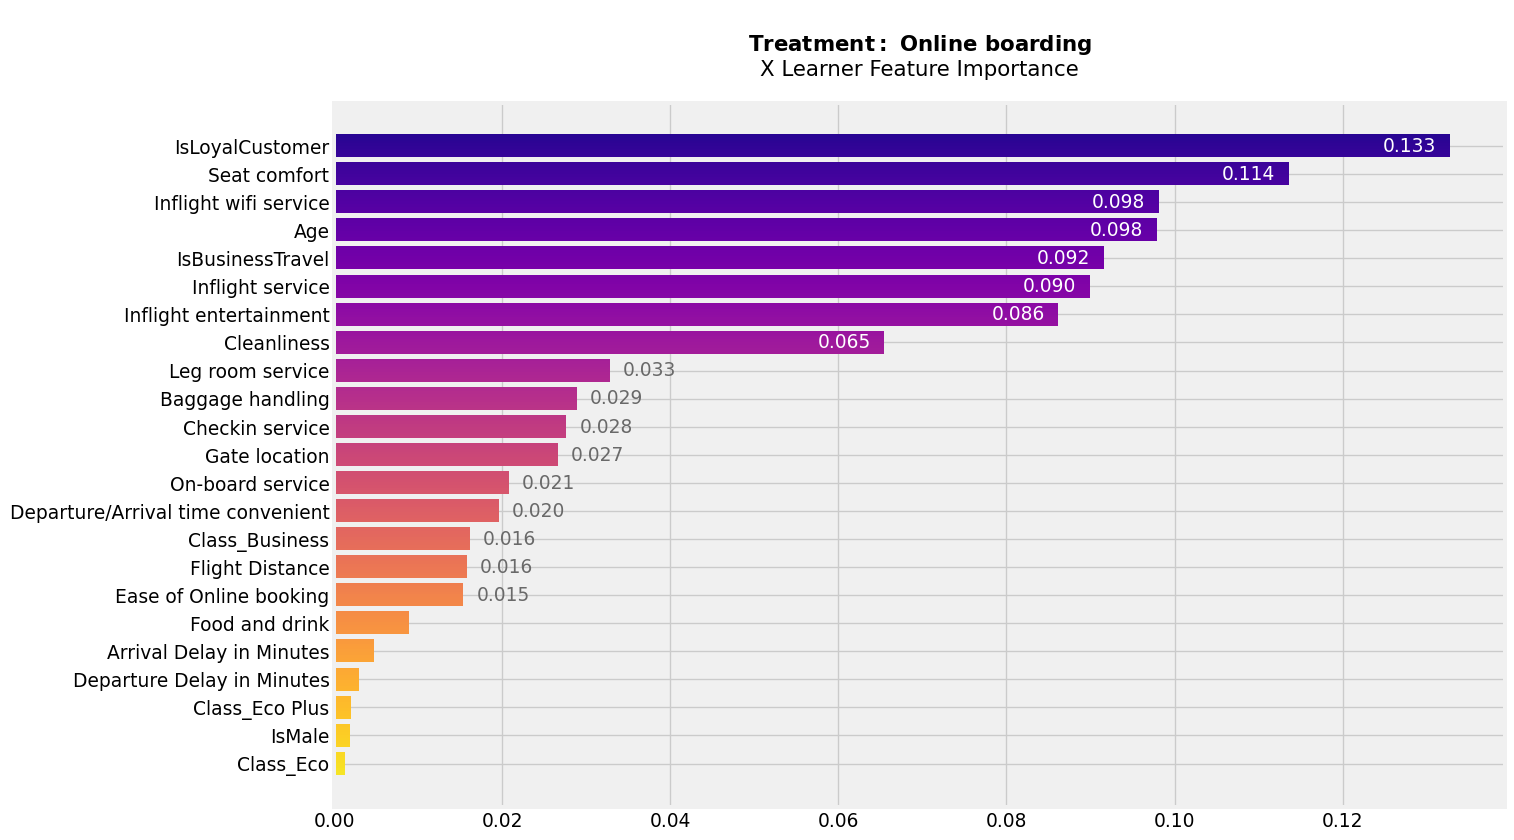

In [56]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 96, facecolor = "white")

bar = ax.barh(importance["Good Online Boarding"].index, importance["Good Online Boarding"])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title("\n"+r"$\bf{Treatment:\ Online\ boarding}$"+"\n"+"X Learner Feature Importance", pad=20, fontsize=16)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}'))

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=1, origin='lower',
                  vmin=ymin, vmax=ymax, cmap="plasma")
    ax.axis([xmin, xmax, ymax, ymin])

gradientbars_sliced(bar)

for rect in ax.patches:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    if x_value > 0.01:
        if x_value < 0.05:
            space = 50
            ha = 'right'
            color = "dimgrey"
        else:
            space = -50
            ha = 'left'
            color = "white"

        label = '{:,.3f}'.format(x_value)

        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords='offset points',
                     va='center', ha=ha, color = color)

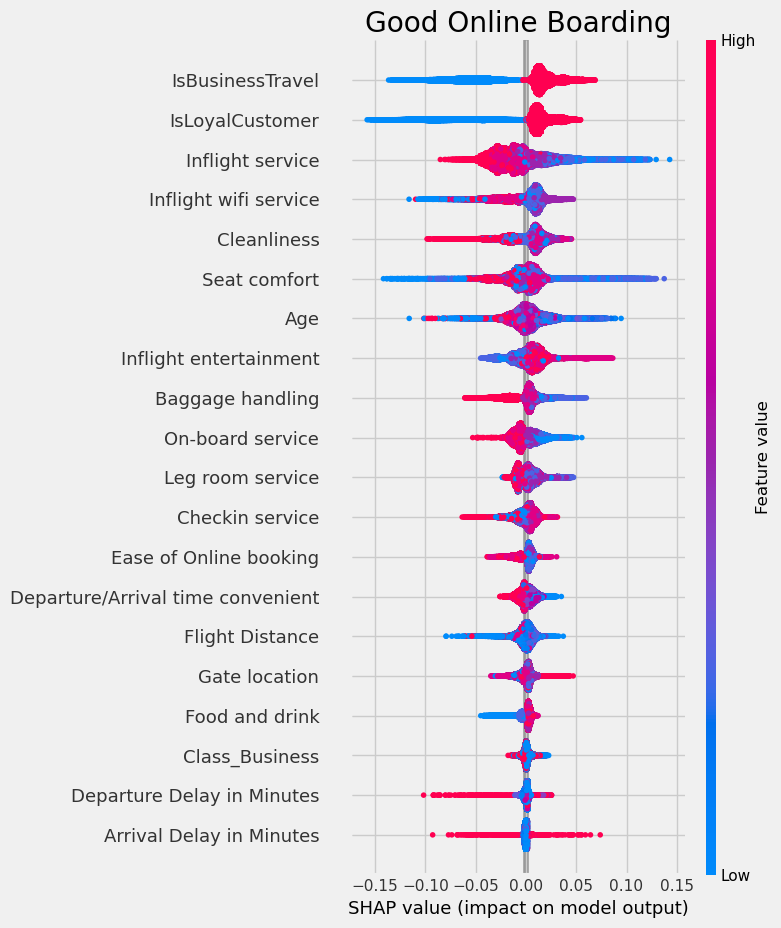

In [57]:
x_learner.plot_shap_values(X = X, tau = x_learner_tau, features = feature_names)

In [58]:
comparison.loc[len(comparison)] = result
display(comparison)

,Meta Learner,Base Model (Regressor),ATE,ATE lb,ATE ub,Top Features (auto)
0,S Learner,XGBoost,0.065257,NA,NA,"[Inflight wifi service, IsLoyalCustomer, Seat comfort]"
1,T Learner,XGBoost,0.055761,0.053636,0.057886,"[Seat comfort, Inflight wifi service, Age]"
2,X Learner,XGBoost,0.046826,0.044866,0.048786,"[IsLoyalCustomer, Seat comfort, Inflight wifi service]"


## CATE II: Online boarding<a name = "c2"></a>

In [59]:
airplane_ITE_t = t_learner.fit_predict(X, treatment, y)
display(airplane_ITE_t)

array([[ 0.06630297],
       [ 0.06216549],
       [ 0.43383056],
       ...,
       [-0.0554261 ],
       [ 0.35226408],
       [ 0.32252926]])

In [60]:
airplane_causal["ITE"] = airplane_ITE_t
display(airplane_causal.head())

,IsMale,IsLoyalCustomer,Age,IsBusinessTravel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Class_Business,Class_Eco,Class_Eco Plus,ITE
0,1,1,13,0,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18,0,0,0,1,0.066303
1,1,0,25,1,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6,0,1,0,0,0.062165
2,0,1,26,1,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0,1,1,0,0,0.433831
3,0,1,25,1,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9,0,1,0,0,0.115174
4,1,1,61,1,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0,1,1,0,0,0.278408


### 1. By IsBusinessTravel<a name = "c2bu"></a>

In [61]:
CATE_bu = airplane_causal[["IsBusinessTravel", "ITE"]]
CATE_bu["IsBusinessTravel"] = np.where(CATE_bu["IsBusinessTravel"] == 1, "Yes", "No")
CATE_bu.groupby(["IsBusinessTravel"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

,CATE
IsBusinessTravel,
No,0.008
Yes,0.077


### 2. By Class + IsBusinessTravel<a name = "c2class"></a>

In [62]:
CATE_class = pd.concat([CATE_bu, airplane["Class"]], axis = 1)
CATE_class.groupby(["IsBusinessTravel","Class"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

### 3. By IsLoyalCustomer<a name = "c2lo"></a>

In [63]:
CATE_lo = airplane_causal[["IsLoyalCustomer", "ITE"]]
CATE_lo["IsLoyalCustomer"] = np.where(CATE_lo["IsLoyalCustomer"] == 1, "Yes", "No")
CATE_lo.groupby(["IsLoyalCustomer"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

,CATE
IsLoyalCustomer,
No,0.019
Yes,0.064


### 4. By Age<a name = "c2age"></a>

In [64]:
CATE_age = airplane_causal[["Age", "ITE"]]
def ageGroup(x):
    if x < 15:
        return "0-15"
    elif x < 41:
        return "18-40"
    elif x < 66:
        return "41-65"
    else:
        return "65+"
CATE_age["Age"] = CATE_age["Age"].apply(lambda x: ageGroup(x))
CATE_age.groupby(["Age"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

,CATE
Age,
0-15,0.027
18-40,0.069
41-65,0.047
65+,0.032
